# Boosting + random forest

In [201]:
%matplotlib inline

In [202]:
import pandas as pd
import numpy as np
import category_encoders as ce
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import sys
import json

import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import precision_score, confusion_matrix, f1_score, make_scorer, explained_variance_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer, StandardScaler

In [203]:
class CatHandler:
    encoders = {
        'ordinal': ce.OrdinalEncoder,
        'target': ce.TargetEncoder,
        'one_hot': ce.OneHotEncoder,
        'leave_one_out': ce.LeaveOneOutEncoder,
    }
    
    def __init__(self, max_categories, params, encoder_type='ordinal'):
        assert encoder_type in self.encoders.keys()
        self._max_categories = max_categories
        self._enc_type = encoder_type
        self._params = params
        self._encoder = None
        
    def fit(self, df, y=None):
        cat_cols = df.select_dtypes(object).columns.tolist() + ['Var118', 'Var73']  # categorical columns
        unique_values = sorted([(col_name, len(df[col_name].unique())) for col_name in cat_cols], key=lambda x: x[1])
        self._chosen_cat_cols = [v[0] for v in unique_values if v[1] < self._max_categories]  # cat columns with less than MAX_CAT unique cats
        self._many_cat_cols = list(set(cat_cols) - set(self._chosen_cat_cols))  # cat columns with more than MAX_CAT unique cats
        
        self._encoder = self.encoders[self._enc_type](cols=self._chosen_cat_cols, **self._params)
        if self._enc_type in ['target', 'leave_one_out']:
            assert not y is None
            self._encoder.fit(df, y)
        else:
            self._encoder.fit(df)
        
    def transform(self, df, y):
        assert not self._encoder is None
        if self._enc_type in ['target', 'leave_one_out'] and not y is None:
            df = self._encoder.transform(df, y)
        else:
            df = self._encoder.transform(df)
        df = df.drop(self._many_cat_cols, axis=1)
        return df

    def fit_transform(self, df, y=None):
        self.fit(df, y)
        return self.transform(df, y)
    
    
class MLNAFiller:
    def __init__(self, fit_na_threshold, fill_na_threshold, strategy='mean', rest_strategy='drop'):
        """
        fit_na_threshold: columns used for training
        fill_na_threshold: columns which will be tried to fill with models
        other_strategy: what to do with bad fills
        
        """
        assert fit_na_threshold < fill_na_threshold
        assert strategy in ['mean', 'median', 'drop', 'leave']
        assert rest_strategy in ['leave', 'drop']
        self._fill_na_threshold = fill_na_threshold
        self._fit_na_threshold = fit_na_threshold
        self._inputer = None
        self._strategy = strategy
        self._rest_strategy = rest_strategy
        if strategy in ['mean', 'median']:
            self._inputer = SimpleImputer(strategy=strategy)
        
    def fit(self, df):     
        self._fit_cols = df.columns[df.isna().mean() < self._fit_na_threshold].tolist()
        to_fill_cols = df.columns[df.isna().mean() <= self._fill_na_threshold]
        self._rest_cols = df.columns[df.isna().mean() > self._fill_na_threshold]
        
        scores = {}
        for fill_col in tqdm(to_fill_cols, desc='Searching for best columns...'):
            fit_cols = ~df[self._fit_cols].columns.isin([fill_col, 'class'])
            non_na_idx = ~df[fill_col].isna()
            model = xgb.sklearn.XGBRegressor(n_estimators=100, n_jobs=-1)
            X = df.loc[non_na_idx, fit_cols]
            y = df.loc[non_na_idx, fill_col]
            train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
            train_X.reset_index(drop=True), train_y.reset_index(drop=True) 
            test_X.reset_index(drop=True), test_y.reset_index(drop=True) 
            model.fit(train_X, train_y)
            pred_y = model.predict(test_X)
            score = explained_variance_score(test_y, pred_y)
            scores[fill_col] = score
            
        chosen_to_fill = [k for k in scores if scores[k] >= 0.8]
        self._inputer_cols = [k for k in scores if scores[k] < 0.8]
        self._models = {}
        
        for fill_col in tqdm(chosen_to_fill, desc='Fitting for best columns...'):
            fit_cols = ~df[self._fit_cols].columns.isin([fill_col, 'class'])
            non_na_idx = ~df[fill_col].isna()
            model = xgb.sklearn.XGBRegressor(n_estimators=100, n_jobs=-1)
            train_X = df.loc[non_na_idx, fit_cols]
            train_y = df.loc[non_na_idx, fill_col]
            model.fit(train_X, train_y)
            self._models[fill_col] = model
            
        if self._strategy in ['mean', 'median']:
            self._inputer.fit(df[self._inputer_cols])
    
    def transform(self, df):
        df = df.copy()
            
        for fill_col, model in tqdm(self._models.items()):
            fit_cols = ~df[self._fit_cols].columns.isin([fill_col, 'class'])
            pred_X = df.loc[:, fit_cols]
            pred_y = model.predict(pred_X)
            df.loc[:, fill_col] = df.loc[:, fill_col].fillna(pd.Series(pred_y))
            
        if self._strategy in ['mean', 'median']:
            df[self._inputer_cols] = self._inputer.transform(df[self._inputer_cols])
        elif self._strategy == 'drop':
            df = df.drop(self._inputer_cols, axis=1)
            
        if self._rest_strategy == 'drop':
            df = df.drop(self._rest_cols, axis=1)
            
        return df
    
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)
    
    
class Preprocessor:
    def __init__(self, cat_handler, na_filler):
        self.cat_handler = cat_handler
        self.na_filler = na_filler
        self.scaler = StandardScaler()
        
    def fit(self, df, y=None):
        na_cols = df.columns[df.isna().all()].tolist()
        df = df.drop(na_cols, axis=1)
        self.na_cols = na_cols
        
        df = self.cat_handler.fit_transform(df, y)
        non_normalize_cols = self.cat_handler._chosen_cat_cols
        features = df.loc[:, ~df.columns.isin(non_normalize_cols)]
        features_cols = features.columns
        df.loc[:, ~df.columns.isin(non_normalize_cols)] = pd.DataFrame(self.scaler.fit_transform(features), columns=features_cols)
        df = self.na_filler.fit(df)
        
    def transform(self, df, y=None):
        df = df.drop(self.na_cols, axis=1)
        df = self.cat_handler.transform(df, y)
        non_normalize_cols = self.cat_handler._chosen_cat_cols
        features = df.loc[:, ~df.columns.isin(non_normalize_cols)]
        features_cols = features.columns
        df.loc[:, ~df.columns.isin(non_normalize_cols)] = pd.DataFrame(self.scaler.transform(features), columns=features_cols)
        df = self.na_filler.transform(df)
        return df
        
    def fit_transform(self, df, y=None):
        self.fit(df, y)
        return self.transform(df, y)

In [5]:
def plot_roc(y_test, y_pred):
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [31]:
df = pd.read_csv('../data/train.txt', sep=' ')
df = df.reset_index(drop=True)
print(f'Columns: {len(df.columns)}')
df.head()

Columns: 231


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,class
0,NaN,NaN,NaN,NaN,NaN,931.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,szEZ,ZI9m,ib5G6X1eUxUn6,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,245.0,7.0,NaN,NaN,NaN,...,bTV7qqc,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,2JfQ3DB,jySVZNlOJy,NaN,ELof,7aLG,RAYp,F2FyR07IdsN7I,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,1036.0,7.0,NaN,NaN,NaN,...,hHJsvbM,LM8l689qOp,NaN,NaN,Qcbd,6fzt,SbOd7O8ky1wGNxp0Arj0Xs,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,518.0,7.0,NaN,NaN,NaN,...,APgVoGr,LM8l689qOp,NaN,NaN,kwS7,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,0


In [32]:
c = CatHandler(max_categories=2000, params={'sigma':0.3}, encoder_type='leave_one_out')
m = MLNAFiller(fit_na_threshold=0.1, fill_na_threshold=0.3, strategy='leave', rest_strategy='drop')
p = Preprocessor(c, m)

In [33]:
df = p.fit_transform(df)
X = df.drop('class', axis=1)
y = df['class']

In [34]:
model = xgb.sklearn.XGBClassifier()
params = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.1],
    'n_estimators': [100],
    'reg_lambda': [1, 3, 5, 7],
}

clf = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc' ,cv=3, n_jobs=-1)
clf.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4], 'learning_rate': [0.1], 'n_estimators': [100], 'reg_lambda': [1, 3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [35]:
clf.best_params_, clf.best_score_

({'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_lambda': 1},
 0.8980316689414872)

### XGBoost final

In [165]:
df = pd.read_csv('../data/train.txt', sep=' ')
df = df.reset_index(drop=True)
print(f'Columns: {len(df.columns)}')
df.head()

Columns: 231


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,class
0,NaN,NaN,NaN,NaN,NaN,931.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,szEZ,ZI9m,ib5G6X1eUxUn6,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,245.0,7.0,NaN,NaN,NaN,...,bTV7qqc,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,2JfQ3DB,jySVZNlOJy,NaN,ELof,7aLG,RAYp,F2FyR07IdsN7I,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,1036.0,7.0,NaN,NaN,NaN,...,hHJsvbM,LM8l689qOp,NaN,NaN,Qcbd,6fzt,SbOd7O8ky1wGNxp0Arj0Xs,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,518.0,7.0,NaN,NaN,NaN,...,APgVoGr,LM8l689qOp,NaN,NaN,kwS7,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,0


In [166]:
train_df, test_df = train_test_split(df, test_size=0.3)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [167]:
c = CatHandler(max_categories=60, params={'smoothing': 300}, encoder_type='target')
m = MLNAFiller(fit_na_threshold=0.1, fill_na_threshold=0.3, strategy='leave', rest_strategy='leave')
p = Preprocessor(c, m)

In [168]:
train_X = train_df.drop('class', axis=1)
train_y = train_df['class']
test_X = test_df.drop('class', axis=1)
test_y = test_df['class']

train_X = p.fit_transform(train_X, train_y)
test_X = p.transform(test_X)

In [169]:
model = xgb.sklearn.XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=100, reg_lambda=0.5)
model.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [170]:
def custom_score(y_true, y_pred):
    ind = np.argsort(y_pred)[::-1]
    check_size = int(np.ceil(0.1 * len(y_true)))
    y_true = y_true[ind][:check_size]
    return np.mean(y_true)

y_preds_proba = model.predict_proba(test_X)[:,1]
c_score = custom_score(test_y, y_preds_proba)
auc = roc_auc_score(test_y, y_preds_proba)
c_score, auc

(0.39416666666666667, 0.8628510677748509)

In [51]:
df = pd.read_csv('../data/train.txt', sep=' ')
df = df.reset_index(drop=True)
print(f'Columns: {len(df.columns)}')
df.head()

Columns: 231


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,class
0,NaN,NaN,NaN,NaN,NaN,931.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,szEZ,ZI9m,ib5G6X1eUxUn6,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,245.0,7.0,NaN,NaN,NaN,...,bTV7qqc,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,2JfQ3DB,jySVZNlOJy,NaN,ELof,7aLG,RAYp,F2FyR07IdsN7I,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,1036.0,7.0,NaN,NaN,NaN,...,hHJsvbM,LM8l689qOp,NaN,NaN,Qcbd,6fzt,SbOd7O8ky1wGNxp0Arj0Xs,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,518.0,7.0,NaN,NaN,NaN,...,APgVoGr,LM8l689qOp,NaN,NaN,kwS7,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,0


In [18]:
c = CatHandler(max_categories=2000, params={}, encoder_type='oridinal')
m = MLNAFiller(fit_na_threshold=0.1, fill_na_threshold=0.3, strategy='leave', rest_strategy='leave')
p = Preprocessor(c, m)

In [19]:
df = p.fit_transform(df)
X = df.drop('class', axis=1)
y = df['class']

/home/bartek/Workspace/venvs/myenv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/bartek/Workspace/venvs/myenv/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


/home/bartek/Workspace/venvs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:141: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [20]:
model = lgb.sklearn.LGBMClassifier()
params = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 300],
    'class_weight': ['balanced', None],
    'reg_lambda': [1, 3, 5],
    'num_leaves': [20, 31, 50]
}

clf = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc' ,cv=3, n_jobs=-1)
clf.fit(X, y, eval_metric='auc', categorical_feature=p.cat_handler._chosen_cat_cols)

/home/bartek/Workspace/venvs/myenv/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Var191', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197', 'Var201', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var213', 'Var215', 'Var216', 'Var218', 'Var219', 'Var221', 'Var223', 'Var224', 'Var225', 'Var226', 'Var227', 'Var228', 'Var229']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'boosting_type': ['gbdt', 'dart', 'goss'], 'max_depth': [2, 3, 4], 'learning_rate': [0.1, 0.01], 'n_estimators': [100, 300], 'class_weight': ['balanced', None], 'reg_lambda': [1, 3, 5], 'num_leaves': [20, 31, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [21]:
clf.best_params_, clf.best_score_

({'boosting_type': 'goss',
  'class_weight': None,
  'learning_rate': 0.01,
  'max_depth': 2,
  'n_estimators': 300,
  'num_leaves': 20,
  'reg_lambda': 3},
 0.8566093906848667)

# Catboost

In [62]:
df = pd.read_csv('../data/train.txt', sep=' ')
df = df.reset_index(drop=True)
print(f'Columns: {len(df.columns)}')
df.head()

Columns: 231


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,class
0,NaN,NaN,NaN,NaN,NaN,931.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,szEZ,ZI9m,ib5G6X1eUxUn6,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,245.0,7.0,NaN,NaN,NaN,...,bTV7qqc,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,2JfQ3DB,jySVZNlOJy,NaN,ELof,7aLG,RAYp,F2FyR07IdsN7I,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,1036.0,7.0,NaN,NaN,NaN,...,hHJsvbM,LM8l689qOp,NaN,NaN,Qcbd,6fzt,SbOd7O8ky1wGNxp0Arj0Xs,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,518.0,7.0,NaN,NaN,NaN,...,APgVoGr,LM8l689qOp,NaN,NaN,kwS7,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,0


In [63]:
c = CatHandler(max_categories=6000, params={}, encoder_type='oridinal')
m = MLNAFiller(fit_na_threshold=0.1, fill_na_threshold=0.2, strategy='leave', rest_strategy='leave')
p = Preprocessor(c, m)

In [64]:
df = p.fit_transform(df)
X = df.drop('class', axis=1)
y = df['class']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [65]:
model = ctb.CatBoostClassifier(iterations=1000, max_depth=6, eval_metric="AUC", task_type='CPU', logging_level='Silent', l2_leaf_reg=1)
cross_validate(model, X, y, scoring='roc_auc', cv=3, n_jobs=-1)

/home/bartek/Workspace/venvs/myenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([189.95339799, 190.54359412, 188.82233453]),
 'score_time': array([0.56518698, 0.33432603, 0.71502805]),
 'test_score': array([0.87626794, 0.85734569, 0.86060237]),
 'train_score': array([0.93664064, 0.9337343 , 0.93165673])}

In [15]:
idx = np.argsort(model.feature_importances_)[::-1][:64]
best_features = np.array(model.feature_names_)[idx]
np.sum(model.feature_importances_[idx])

CatBoostError: There is no trained model to use `feature_importances_`. Use fit() to train model. Then use `feature_importances_`.

In [96]:
model.fit(train_X[best_features], train_y)

In [97]:
y_preds_proba = model.predict_proba(test_X[best_features])[:,1]
c_score = custom_score(test_y.values, y_preds_proba)
auc = roc_auc_score(test_y.values, y_preds_proba)
c_score, auc

(0.3933333333333333, 0.8662838252125573)

In [40]:
model = ctb.CatBoostClassifier()
params = {
    'eval_metric': ["AUC"], 
    'task_type': ['CPU'], 
    'logging_level': ['Silent'],
    'iterations': [500, 1000],
    'reg_lambda': [1, 6, 10],
    'max_depth': [4, 6],
    'one_hot_max_size': [1, 2, 10],
    'loss_function': ['Logloss', 'CrossEntropy'],
    'learning_rate': [0.1, 0.03]
}

clf = GridSearchCV(estimator=model, param_grid=params, fit_params={'cat_features': p.cat_handler._chosen_cat_cols},
                   scoring='roc_auc' ,cv=3, n_jobs=4)
clf.fit(X, y)

/home/bartek/Workspace/venvs/myenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=<catboost.core.CatBoostClassifier object at 0x7fbc52588a20>,
       fit_params={'cat_features': ['Var191', 'Var211', 'Var213', 'Var215', 'Var224', 'Var118', 'Var196', 'Var201', 'Var208', 'Var218', 'Var194', 'Var205', 'Var225', 'Var223', 'Var229', 'Var203', 'Var210', 'Var221', 'Var227', 'Var207', 'Var206', 'Var195', 'Var219', 'Var226', 'Var228', 'Var193', 'Var212', 'Var204', 'Var73', 'Var197', 'Var192', 'Var216']},
       iid='warn', n_jobs=4,
       param_grid={'eval_metric': ['AUC'], 'task_type': ['CPU'], 'logging_level': ['Silent'], 'iterations': [500, 1000], 'reg_lambda': [1, 6, 10], 'max_depth': [4, 6], 'one_hot_max_size': [1, 2, 10], 'loss_function': ['Logloss', 'CrossEntropy'], 'learning_rate': [0.1, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [41]:
clf.best_params_, clf.best_score_

({'eval_metric': 'AUC',
  'iterations': 1000,
  'learning_rate': 0.03,
  'logging_level': 'Silent',
  'loss_function': 'Logloss',
  'max_depth': 6,
  'one_hot_max_size': 2,
  'reg_lambda': 1,
  'task_type': 'CPU'},
 0.867432508711517)

### Catboost final

In [235]:
df = pd.read_csv('../data/train.txt', sep=' ')
df = df.reset_index(drop=True)
print(f'Columns: {len(df.columns)}')
df.head()

Columns: 231


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,class
0,NaN,NaN,NaN,NaN,NaN,931.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,szEZ,ZI9m,ib5G6X1eUxUn6,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,245.0,7.0,NaN,NaN,NaN,...,bTV7qqc,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,2JfQ3DB,jySVZNlOJy,NaN,ELof,7aLG,RAYp,F2FyR07IdsN7I,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,1036.0,7.0,NaN,NaN,NaN,...,hHJsvbM,LM8l689qOp,NaN,NaN,Qcbd,6fzt,SbOd7O8ky1wGNxp0Arj0Xs,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,518.0,7.0,NaN,NaN,NaN,...,APgVoGr,LM8l689qOp,NaN,NaN,kwS7,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,0


In [241]:
train_df, test_df = train_test_split(df, test_size=0.3)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [242]:
c = CatHandler(max_categories=2000, params={}, encoder_type='ordinal')
m = MLNAFiller(fit_na_threshold=0.1, fill_na_threshold=0.3, strategy='leave', rest_strategy='leave')
p = Preprocessor(c, m)

In [243]:
train_X = train_df.drop('class', axis=1)
train_y = train_df['class']
test_X = test_df.drop('class', axis=1)
test_y = test_df['class']

train_X = p.fit_transform(train_X, train_y)
test_X = p.transform(test_X)

In [244]:
model = ctb.CatBoostClassifier(iterations=1000, depth=6, eval_metric="AUC", task_type='GPU', logging_level='Silent', l2_leaf_reg=1)
model.fit(train_X, train_y, cat_features=p.cat_handler._chosen_cat_cols)
y_preds_proba = model.predict_proba(test_X)[:,1]
auc = roc_auc_score(test_y.values, y_preds_proba)
auc

0.8696410751630314

In [245]:
y_preds_proba = model.predict_proba(test_X)[:,1]
c_score = custom_score(test_y, y_preds_proba)
auc = roc_auc_score(test_y, y_preds_proba)
c_score, auc

(0.42833333333333334, 0.8696410751630314)

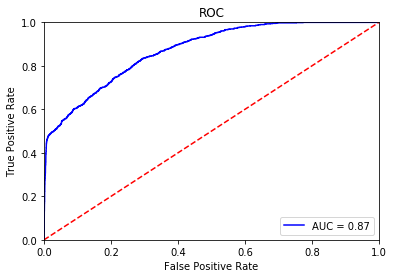

In [178]:
plot_roc(test_y, y_preds_proba)

In [246]:
y_preds_proba = model.predict_proba(train_X)[:,1]
c_score = custom_score(train_y, y_preds_proba)
auc = roc_auc_score(train_y, y_preds_proba)
c_score, auc

(0.45035714285714284, 0.8937361693544064)

In [116]:
df = pd.read_csv('../data/train.txt', sep=' ')
df = df.reset_index(drop=True)
print(f'Columns: {len(df.columns)}')
df.head()

Columns: 231


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,class
0,NaN,NaN,NaN,NaN,NaN,931.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,szEZ,ZI9m,ib5G6X1eUxUn6,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,245.0,7.0,NaN,NaN,NaN,...,bTV7qqc,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,2JfQ3DB,jySVZNlOJy,NaN,ELof,7aLG,RAYp,F2FyR07IdsN7I,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,1036.0,7.0,NaN,NaN,NaN,...,hHJsvbM,LM8l689qOp,NaN,NaN,Qcbd,6fzt,SbOd7O8ky1wGNxp0Arj0Xs,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,518.0,7.0,NaN,NaN,NaN,...,APgVoGr,LM8l689qOp,NaN,NaN,kwS7,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,0


In [131]:
c = CatHandler(max_categories=200, params={'sigma': 0.5}, encoder_type='leave_one_out')
m = MLNAFiller(fit_na_threshold=0.1, fill_na_threshold=0.3, strategy='leave', rest_strategy='leave')
p = Preprocessor(c, m)

In [132]:
train_df, test_df = train_test_split(df, test_size=0.3)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df = p.fit_transform(train_df)
test_df = p.transform(test_df)

train_X = train_df.drop('class', axis=1)
train_y = train_df['class']
test_X = test_df.drop('class', axis=1)
test_y = test_df['class']

In [133]:
model = ctb.CatBoostClassifier(iterations=1000, depth=6, eval_metric="AUC", task_type='GPU', logging_level='Silent', l2_leaf_reg=1)
model.fit(train_X, train_y)#, cat_features=p.cat_handler._chosen_cat_cols)
y_preds_proba = model.predict_proba(test_X)[:,1]
auc = roc_auc_score(test_y.values, y_preds_proba)
c_score = custom_score(test_y, y_preds_proba)
auc, c_score

(0.8674107295725213, 0.3925)

## Random Forest

In [49]:
df = pd.read_csv('../data/train.txt', sep=' ')
df = df.reset_index(drop=True)
print(f'Columns: {len(df.columns)}')
df.head()

Columns: 231


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,class
0,NaN,NaN,NaN,NaN,NaN,931.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,szEZ,ZI9m,ib5G6X1eUxUn6,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,245.0,7.0,NaN,NaN,NaN,...,bTV7qqc,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,2JfQ3DB,jySVZNlOJy,NaN,ELof,7aLG,RAYp,F2FyR07IdsN7I,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,1036.0,7.0,NaN,NaN,NaN,...,hHJsvbM,LM8l689qOp,NaN,NaN,Qcbd,6fzt,SbOd7O8ky1wGNxp0Arj0Xs,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,518.0,7.0,NaN,NaN,NaN,...,APgVoGr,LM8l689qOp,NaN,NaN,kwS7,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,0


In [108]:
c = CatHandler(max_categories=2000, params={}, encoder_type='oridinal')
m = MLNAFiller(fit_na_threshold=0.1, fill_na_threshold=0.3, strategy='mean', rest_strategy='drop')
p = Preprocessor(c, m)

In [109]:
df = p.fit_transform(df)
X = df.drop('class', axis=1)
y = df['class']

/home/bartek/Workspace/venvs/myenv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/bartek/Workspace/venvs/myenv/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


/home/bartek/Workspace/venvs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:141: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [110]:
model = RandomForestClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 20, 100, 200],
    'class_weight': ['balanced', None],
    'n_estimators': [100, 500]
}

clf = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc' ,cv=3, n_jobs=-1)
clf.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 20, 100, 200], 'class_weight': ['balanced', None], 'n_estimators': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [111]:
clf.best_params_, clf.best_score_

({'class_weight': 'balanced',
  'criterion': 'entropy',
  'min_samples_split': 200,
  'n_estimators': 500},
 0.8631230021331961)

In [180]:
df = pd.read_csv('../data/train.txt', sep=' ')
df = df.reset_index(drop=True)
print(f'Columns: {len(df.columns)}')
df.head()

Columns: 231


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,class
0,NaN,NaN,NaN,NaN,NaN,931.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,szEZ,ZI9m,ib5G6X1eUxUn6,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,245.0,7.0,NaN,NaN,NaN,...,bTV7qqc,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,2JfQ3DB,jySVZNlOJy,NaN,ELof,7aLG,RAYp,F2FyR07IdsN7I,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,1036.0,7.0,NaN,NaN,NaN,...,hHJsvbM,LM8l689qOp,NaN,NaN,Qcbd,6fzt,SbOd7O8ky1wGNxp0Arj0Xs,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,518.0,7.0,NaN,NaN,NaN,...,APgVoGr,LM8l689qOp,NaN,NaN,kwS7,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,0


In [182]:
train_df, test_df = train_test_split(df, test_size=0.3)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [189]:
c = CatHandler(max_categories=60, params={'smoothing': 300}, encoder_type='target')
m = MLNAFiller(fit_na_threshold=0.1, fill_na_threshold=0.3, strategy='median', rest_strategy='drop')
p = Preprocessor(c, m)

In [190]:
train_X = train_df.drop('class', axis=1)
train_y = train_df['class']
test_X = test_df.drop('class', axis=1)
test_y = test_df['class']

train_X = p.fit_transform(train_X, train_y)
test_X = p.transform(test_X)


In [191]:
model = RandomForestClassifier(class_weight='balanced', criterion='entropy', n_jobs=-1, n_estimators=500, min_samples_split=200)
model.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [192]:
y_preds_proba = model.predict_proba(test_X)[:,1]
c_score = custom_score(test_y, y_preds_proba)
auc = roc_auc_score(test_y, y_preds_proba)
c_score, auc

(0.37333333333333335, 0.8536198583376001)

In [148]:
idx = np.argsort(model.feature_importances_)[::-1][:32]
best_features = np.array(train_df.columns)[idx]
np.sum(model.feature_importances_[idx])

0.9279128704756114

In [149]:
model.fit(train_X[best_features], train_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [150]:
y_preds_proba = model.predict_proba(test_X[best_features])[:,1]
c_score = custom_score(test_y.values, y_preds_proba)
auc = roc_auc_score(test_y.values, y_preds_proba)
c_score, auc

(0.4041666666666667, 0.8649571930592411)

# Ensemble

In [151]:
df = pd.read_csv('../data/train.txt', sep=' ')
df = df.reset_index(drop=True)
print(f'Columns: {len(df.columns)}')
df.head()

Columns: 231


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,class
0,NaN,NaN,NaN,NaN,NaN,931.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,szEZ,ZI9m,ib5G6X1eUxUn6,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,245.0,7.0,NaN,NaN,NaN,...,bTV7qqc,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,2JfQ3DB,jySVZNlOJy,NaN,ELof,7aLG,RAYp,F2FyR07IdsN7I,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,1036.0,7.0,NaN,NaN,NaN,...,hHJsvbM,LM8l689qOp,NaN,NaN,Qcbd,6fzt,SbOd7O8ky1wGNxp0Arj0Xs,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,518.0,7.0,NaN,NaN,NaN,...,APgVoGr,LM8l689qOp,NaN,NaN,kwS7,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,0


In [152]:
train_df, test_df = train_test_split(df, test_size=0.3)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [153]:
c1 = CatHandler(max_categories=60, params={'smoothing': 300}, encoder_type='target')
m1 = MLNAFiller(fit_na_threshold=0.1, fill_na_threshold=0.3, strategy='leave', rest_strategy='leave')
p1 = Preprocessor(c1, m1)

c2 = CatHandler(max_categories=2000, params={}, encoder_type='ordinal')
m2 = MLNAFiller(fit_na_threshold=0.1, fill_na_threshold=0.3, strategy='leave', rest_strategy='leave')
p2 = Preprocessor(c2, m2)

In [175]:
train_X = train_df.drop('class', axis=1)
train_y = train_df['class']
test_X = test_df.drop('class', axis=1)
test_y = test_df['class']

train_X1 = p1.fit_transform(train_X, train_y)
test_X1 = p1.transform(test_X)

train_X2 = p2.fit_transform(train_X, train_y)
test_X2 = p2.transform(test_X)

In [176]:
model1 = xgb.sklearn.XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=100, reg_lambda=0.5)
model1.fit(train_X1, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [177]:
model2 = ctb.CatBoostClassifier(iterations=1000, depth=6, eval_metric="AUC", task_type='GPU', logging_level='Silent', l2_leaf_reg=1)
model2.fit(train_X2, train_y, cat_features=p2.cat_handler._chosen_cat_cols)

In [179]:
y_preds_proba1 = model1.predict_proba(test_X1)[:,1]
y_preds_proba2 = model2.predict_proba(test_X2)[:,1]
y_preds_proba = (y_preds_proba1 * 0.3 + y_preds_proba2)
c_score = custom_score(test_y, y_preds_proba)
auc = roc_auc_score(test_y, y_preds_proba)
c_score, auc

(0.3983333333333333, 0.8665140086206897)